In [1]:
import os, pathlib

file_path = os.path.dirname(os.path.realpath("__file__"))
home_dir = pathlib.Path(file_path).parent.parent.parent
os.chdir(home_dir)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from src.utils import get_optimizer, SAVED_CLASSIFIER_PATH_FASHION, keras_dataset_image_preprocessing, DENSE_LAYER_NAME

from src.vae import ClaDecVAE, RefVAE

tf.random.set_seed(1234)

(train_images, train_labels_c), (test_images, test_labels_c) = keras_dataset_image_preprocessing(
    keras.datasets.fashion_mnist)
# get the trained model and check accuracy on test data for later reference
classifier = keras.models.load_model(SAVED_CLASSIFIER_PATH_FASHION)

2022-07-09 18:37:00.586346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 18:37:00.619192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 18:37:00.619510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 18:37:00.620189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
classifier.evaluate(test_images, test_labels_c)
classifier.summary()

2022-07-09 18:37:02.479231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


313/313 [==============================] - 2s 3ms/step - loss: 0.2533 - categorical_accuracy: 0.9101
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)     

In [4]:
alpha = 0.01
latent_dim = 2
claDec = ClaDecVAE(classifier, DENSE_LAYER_NAME, alpha, latent_dim)
claDec.compile(optimizer=get_optimizer())

In [5]:
claDec.fit(train_images, train_labels_c, epochs=10)
# alpha = 0.9
# lr = 0.001
# after 10 epochs loss: 91.1961 - reconstruction_loss: 0.1428 - kl_loss: 68.2714 - classification_loss: 1.4681

# lr = 0.01
# after 10 epochs loss: 24.4397 - reconstruction_loss: 0.4585 - kl_loss: 20.9465 - classification_loss: 2.5816

# lr = 0.005
# after 10 epochs loss: 898.9673 - reconstruction_loss: 0.4807 - kl_loss: 2674.8003 - classification_loss: 3.2722

# alpha = 0.1
# lr = 0.001
# after 10 epochs loss: 91.2922 - reconstruction_loss: 0.0778 - kl_loss: 69.1023 - classification_loss: 1.7373

# alpha = 0.01
# lr = 0.001
# after 10 epochs loss: 91.4086 - reconstruction_loss: 0.0779 - kl_loss: 69.2922 - classification_loss: 1.9501

Epoch 1/10
1875/1875 [==============================] - 30s 15ms/step - loss: 23783460.7697 - reconstruction_loss: 0.0940 - kl_loss: 6784160.5000 - classification_loss: 4.3797
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 99374.5327 - reconstruction_loss: 0.0841 - kl_loss: 101455.1562 - classification_loss: 1.8990
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 41216.5064 - reconstruction_loss: 0.0778 - kl_loss: 35998.6211 - classification_loss: 1.7615
Epoch 4/10
1875/1875 [==============================] - 29s 15ms/step - loss: 13560.1252 - reconstruction_loss: 0.0753 - kl_loss: 13570.5283 - classification_loss: 1.7593
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 8581.6061 - reconstruction_loss: 0.0737 - kl_loss: 5706.0903 - classification_loss: 1.7572
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 3325.0688 - reconstruction_loss: 0.0739 - kl_loss: 2516.5913 - 

In [16]:
refvae = RefVAE(claDec)
refvae.compile(keras.optimizers.Adam(learning_rate=0.01))
refvae.fit(train_images, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 28s 15ms/step - loss: 375.3978 - reconstruction_loss: 279.6868 - kl_loss: 14.2459
Epoch 2/5
1875/1875 [==============================] - 28s 15ms/step - loss: 271.8694 - reconstruction_loss: 265.4578 - kl_loss: 6.0870
Epoch 3/5
1875/1875 [==============================] - 28s 15ms/step - loss: 269.6505 - reconstruction_loss: 263.1504 - kl_loss: 6.0948
Epoch 4/5
1875/1875 [==============================] - 28s 15ms/step - loss: 268.1014 - reconstruction_loss: 262.1967 - kl_loss: 6.2766
Epoch 5/5
1875/1875 [==============================] - 31s 17ms/step - loss: 268.1805 - reconstruction_loss: 262.7329 - kl_loss: 6.3633


In [17]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=30):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
            i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


def plot_label_clusters(vae, data, classes):
    # display a 2D plot of the classes in the latent space
    z_mean, z_log_var, reconstruction = vae(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=classes)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


test_labels = np.argmax(test_labels_c, axis=1)
train_labels = np.argmax(train_labels_c, axis=1)
encoding = ["T-Shirt (Top)", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

1/1 [==============================] - 0s 21ms/step


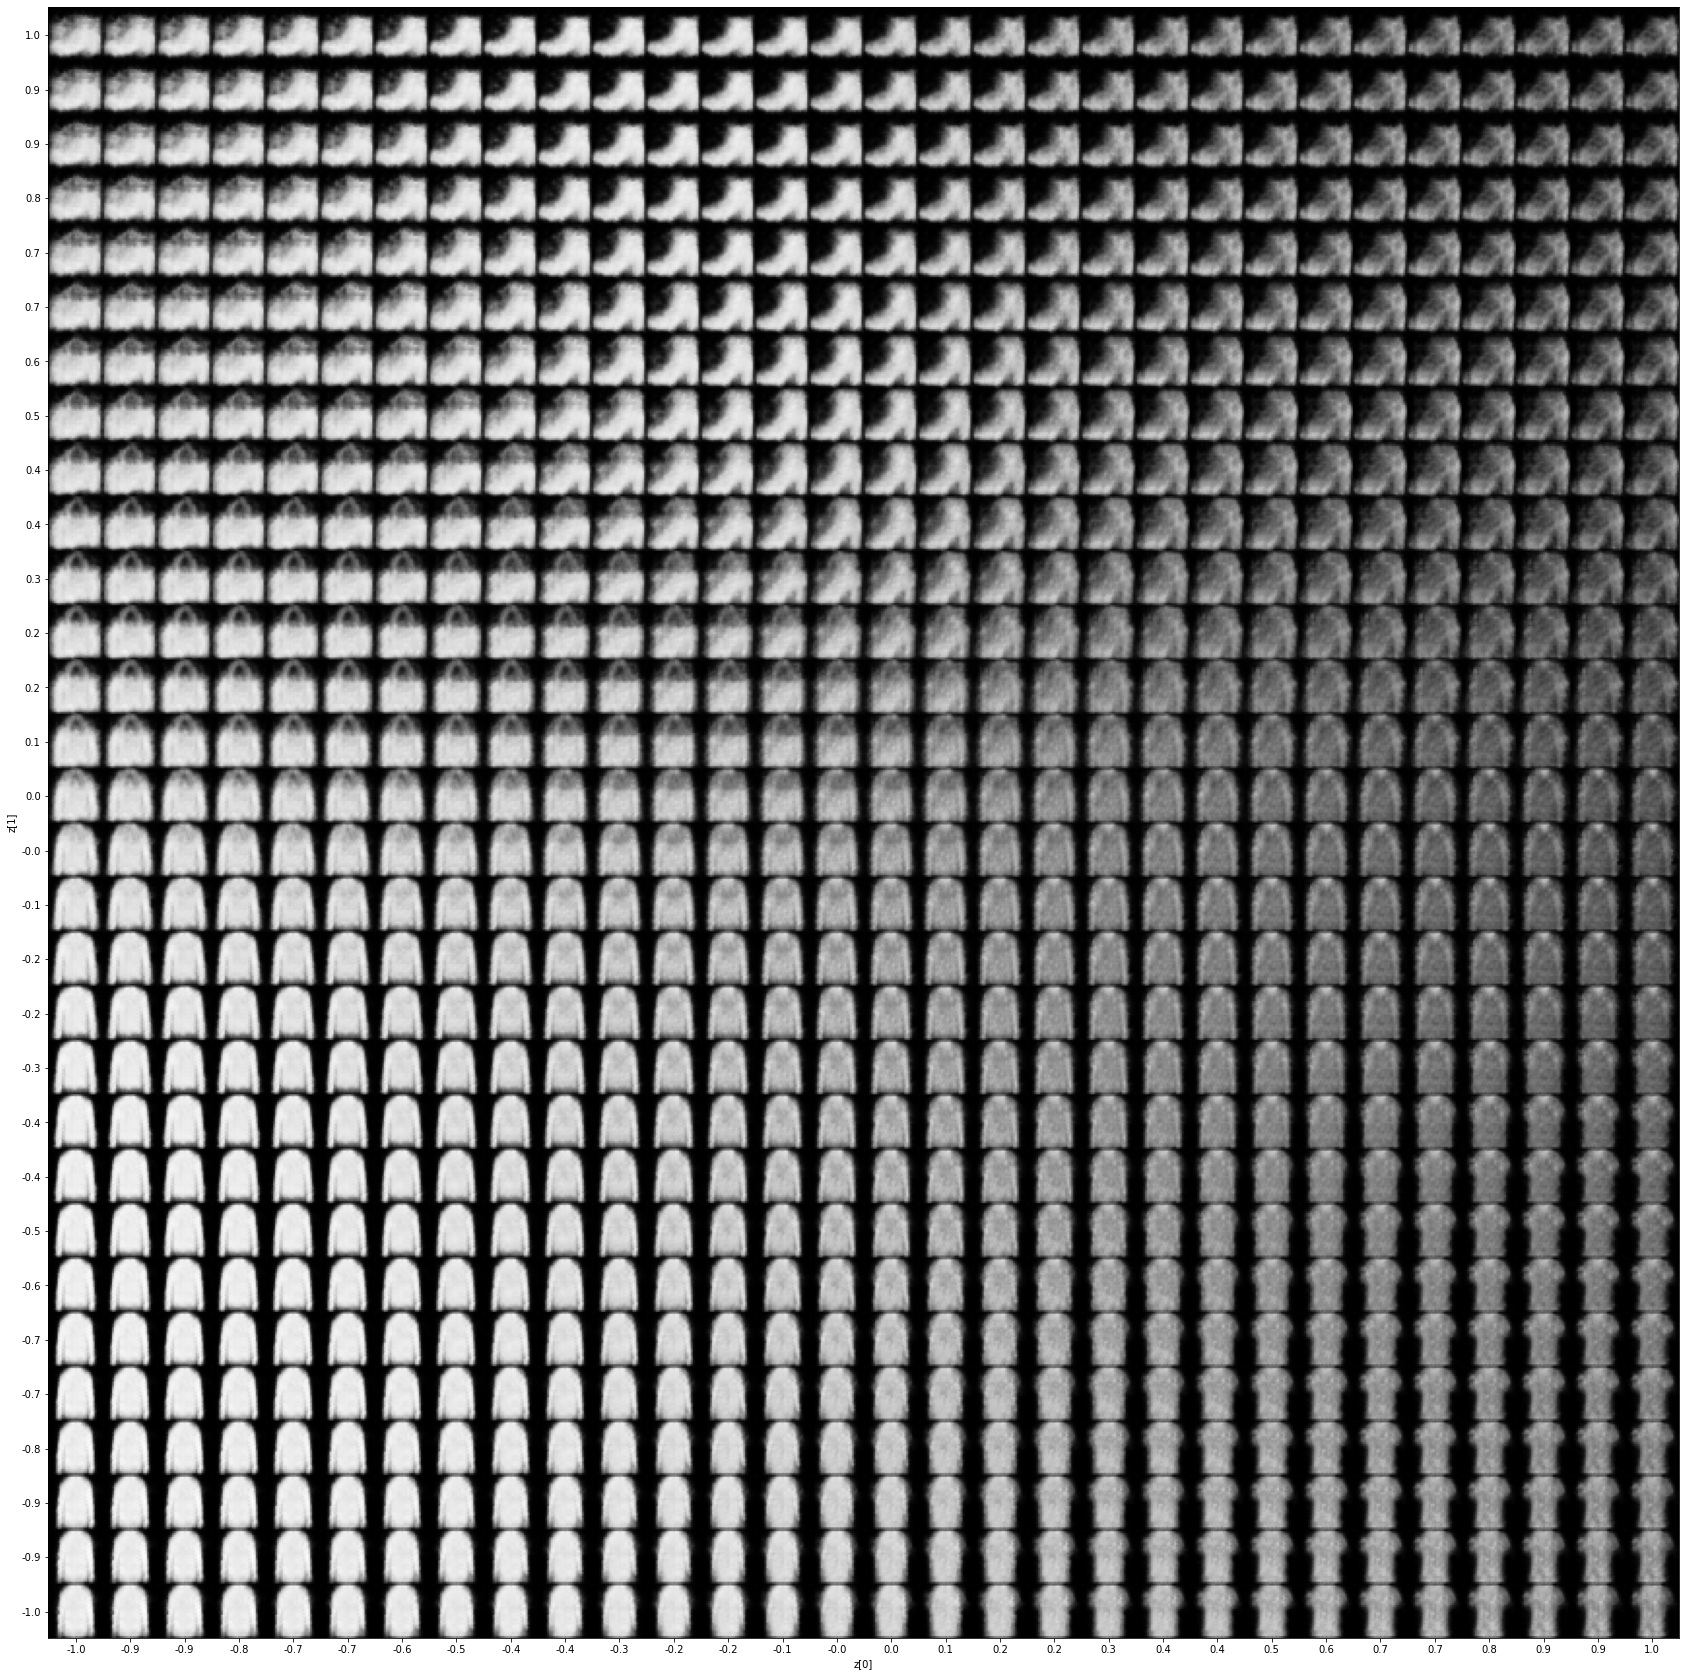

In [18]:
plot_latent_space(refvae)

1/1 [==============================] - 0s 18ms/step


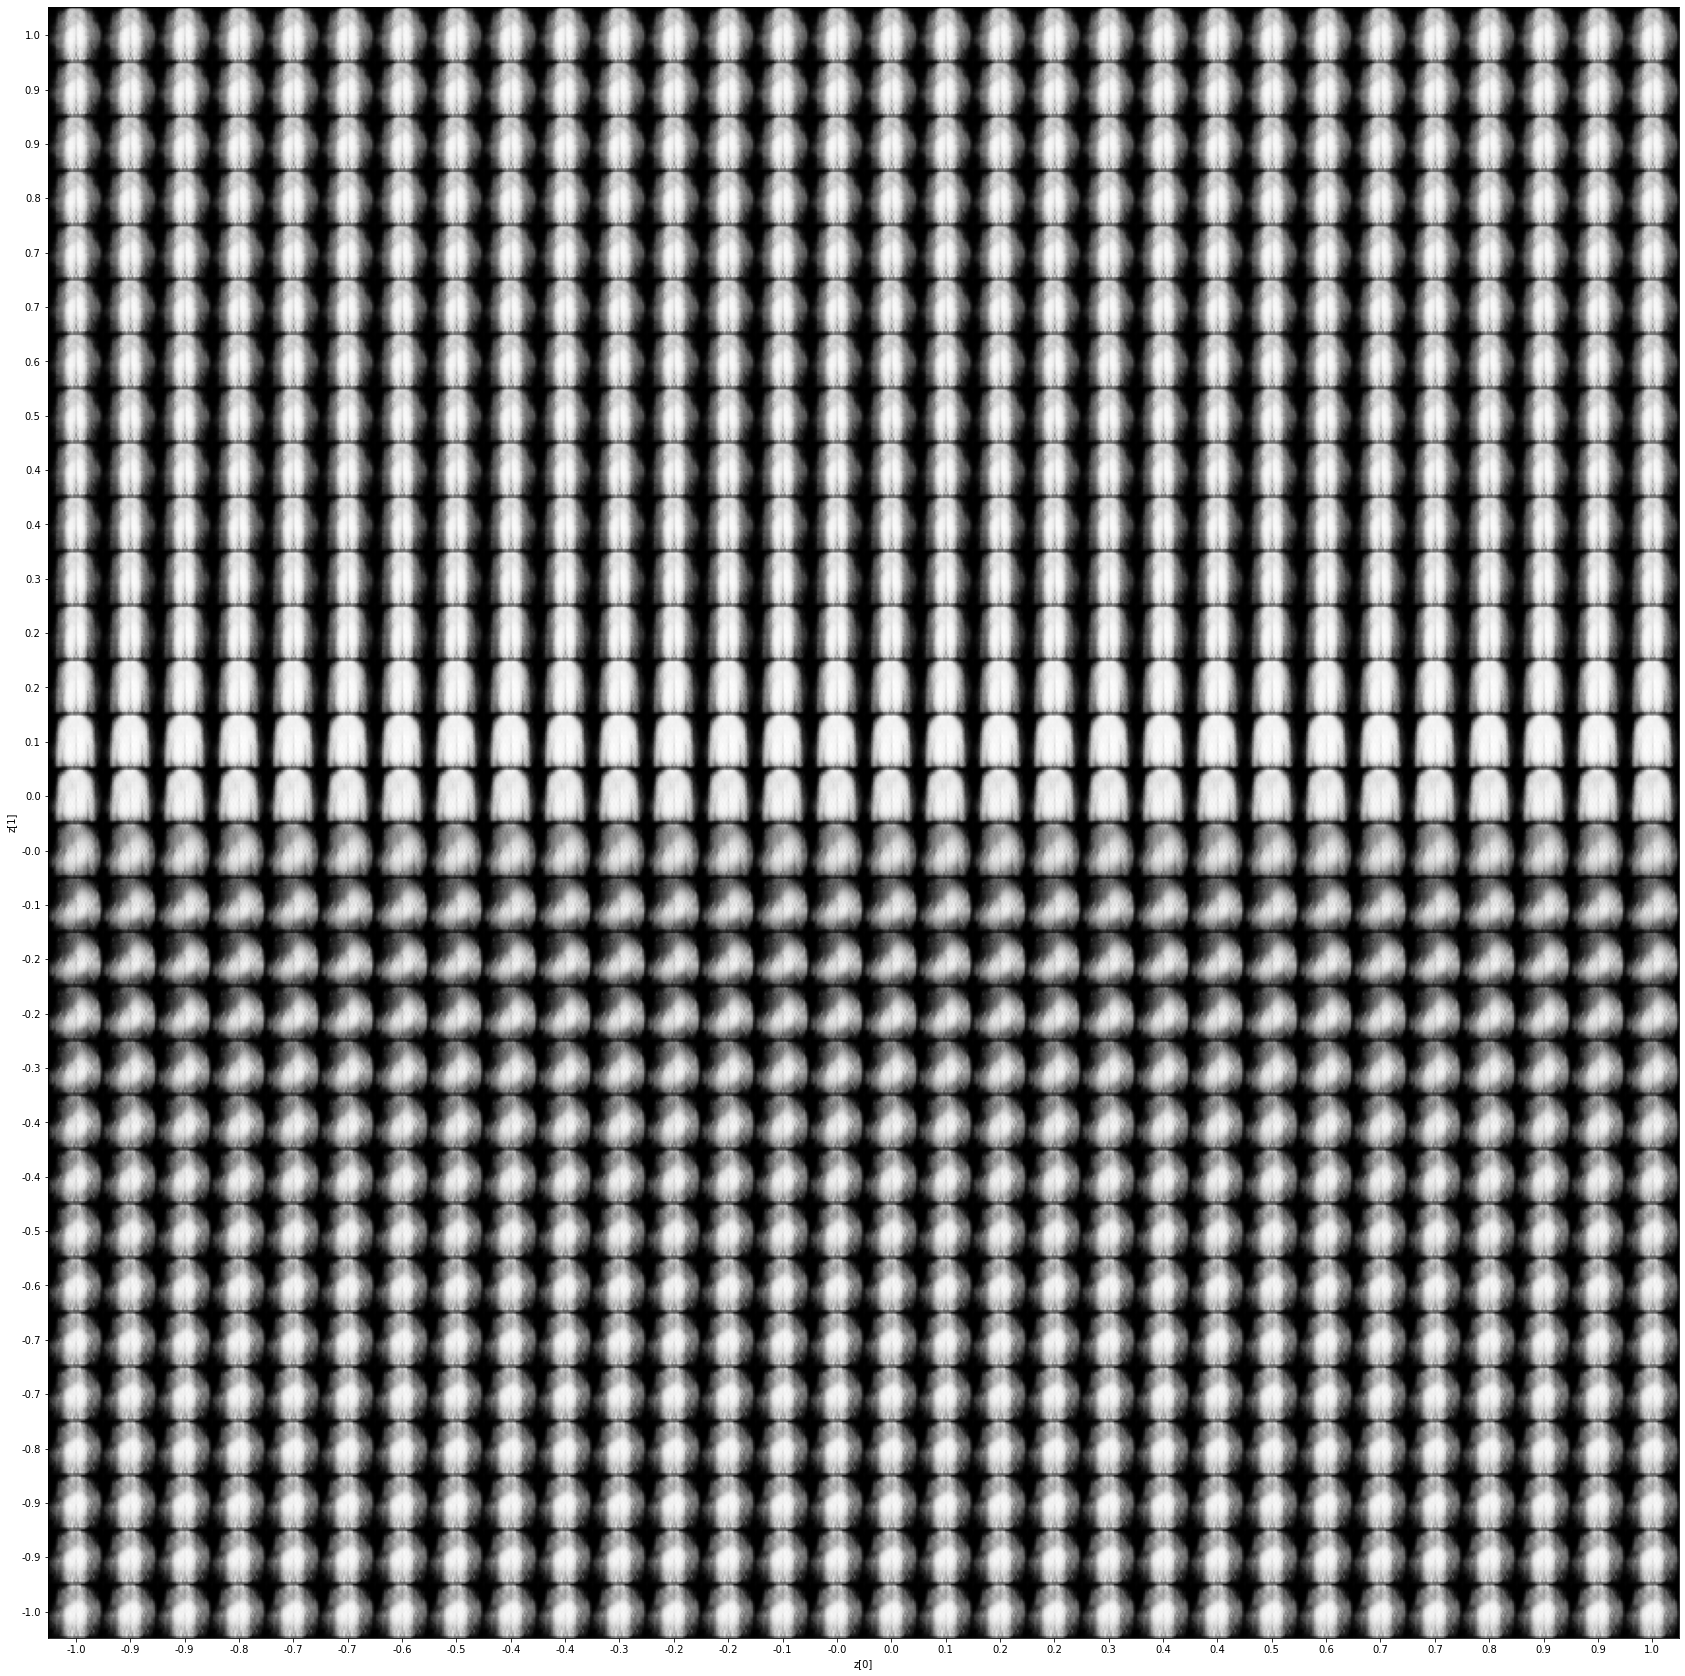

In [19]:
plot_latent_space(claDec)

2022-07-09 18:55:11.738394: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-09 18:55:11.808019: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.75GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-09 18:55:12.448335: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-09 18:55:13.530181: W tensorflow/core/common_runtime/bfc_allocato

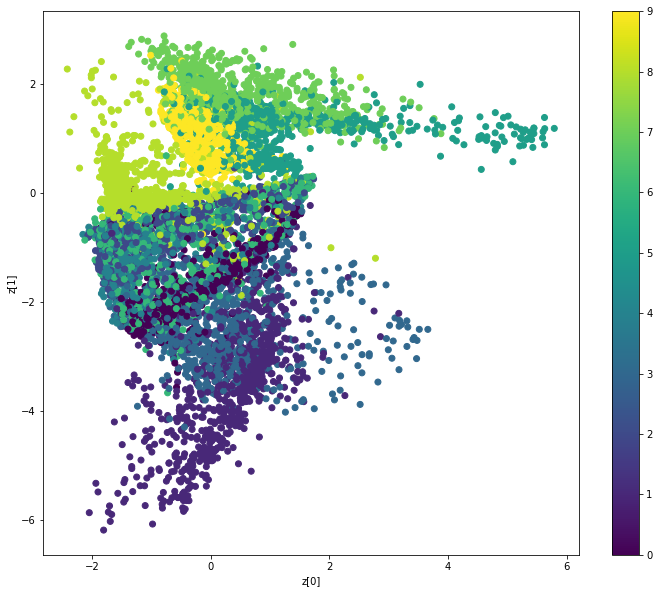

In [20]:
plot_label_clusters(refvae, train_images[:8000], train_labels[:8000])

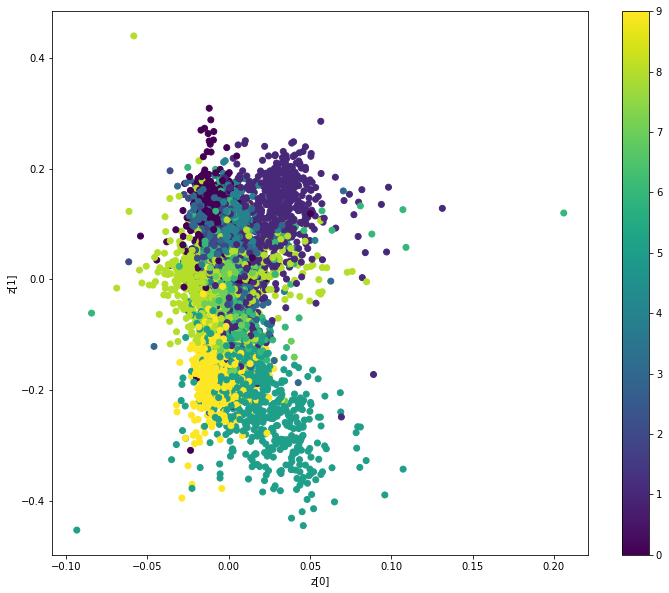

In [21]:
plot_label_clusters(claDec, train_images[:8000], train_labels[:8000])